## Importing Libraries

In [1]:
# %pip install tensorflow keras keras-tuner opencv-python matplotlib pandas

In [2]:
import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
import tensorflow as tf
import time
import keras_tuner as kt
import os

from keras.utils import image_dataset_from_directory, load_img
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Rescaling
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend


## EDA

In [3]:
picture_size = 48
folder_path = "../Ht23-Deep-Learning-Tentamen/images/"

In [4]:
os.listdir(folder_path+"train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

angry


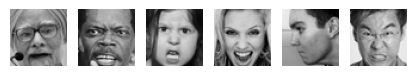

disgust


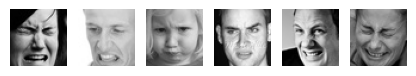

fear


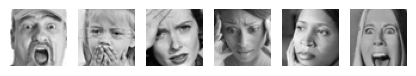

happy


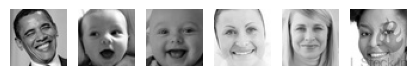

neutral


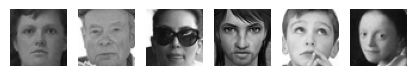

sad


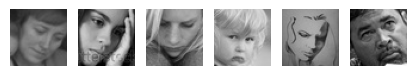

surprise


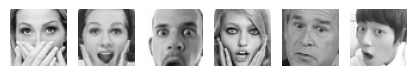

In [5]:
# List of directories containing all expressions
expression = list(os.listdir(folder_path+"train"))

# Plot subplot without labels
for exp in expression:
    plt.figure(figsize= (6,6))
    print(exp)
    for i in range(1, 7, 1):
        plt.subplot(1,7,i)
        plt.axis('off')
        img = load_img(folder_path+"train/"+exp+"/"+
                       os.listdir(folder_path + "train/" + exp)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()


# Making Training and Validation Data

In [60]:
batch_size  = 32

# tf.keras.utils.image_dataset_from_directory
train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels="inferred",
    # label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size
    )

val_ds = image_dataset_from_directory(
    folder_path+"validation",
    labels="inferred",
    # label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
    )

Found 28823 files belonging to 7 classes.
Using 23059 files for training.
Found 7066 files belonging to 7 classes.
Using 1413 files for validation.


In [61]:
# Normalization layer
normalization_layer = Rescaling(1./255)

# Normalizes the training and validation datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Take 10 images from the normalized datasets to speed up training while testing
# normalized_train_ds = normalized_train_ds.take(10)
# normalized_val_ds = normalized_val_ds.take(10)

In [62]:
# Caches the datasets to memory to prevent I/O bottleneck
AUTOTUNE = tf.data.AUTOTUNE

normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

In [10]:
# def build_model(hp):
#     no_of_classes = 7
#     input_shape = (48, 48, 1)

#     model = Sequential()

#     # Tune the first two convolutional layers in the stack _with_ kernel size tuning
#     for i in range(2):
#         model.add(Conv2D(
#             # Tune the number of filters separately in each convolutional layer
#             filters=hp.Int(f"units_{i}", min_value=32, max_value=156, step=32),
#             # Tune the kernel size and stride separately in each convolutional layer
#             kernel_size=hp.Int(f"units_{i}", min_value=3, max_value=5, step=2),
#             padding='same',
#             activation='relu',
#             input_shape=input_shape
#             )
#         )
#         model.add(BatchNormalization())
#         model.add(MaxPooling2D(pool_size=2))
#         if hp.Boolean("dropout"):
#             model.add(Dropout(rate=0.25))

#     # Tunes the number of convolutional layers in the stack _without_ kernel size tuning. Filters min_value is set to double the max_value of the previous layer
#     for i in range(hp.Int("conv_layers", 1, 2)):
#         model.add(Conv2D(
#             filters=hp.Int(f"units_{i}", min_value=312, max_value=576, step=32),
#             kernel_size=3,
#             padding='same',
#             activation='relu',
#             )
#         )
#         model.add(BatchNormalization())
#         model.add(MaxPooling2D(pool_size=2))
#         if hp.Boolean("dropout"):
#             model.add(Dropout(rate=0.25))

#     model.add(Flatten())

#     # Tune the number of dense layers in the model
#     for i in range(hp.Int("dense_layers", 1, 2)):
#         model.add(
#             Dense(
#                 # Tune the number of units separately in each dense layer
#                 hp.Int(f"units_{i}", min_value=192, max_value=576, step=32),
#                 activation='relu'
#             )
#         )
#         model.add(BatchNormalization())
#         if hp.Boolean("dropout"):
#             model.add(Dropout(rate=0.25))

#     model.add(Dense(no_of_classes, activation='softmax'))

#     # Tune the learning rate for the optimizer
#     learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss="categorical_crossentropy",
#         metrics=["accuracy"],
#     )
#     return model

In [21]:
# Load the pre-trained model
pretrained_model = load_model('../Ht23-Deep-Learning-Tentamen/models/model_pre_trained.h5')

def build_from_pre_built(hp):
    # Create a new model based on the pre-trained model
    model = pretrained_model

    # # Add an additional dense to the pre-trained model
    # model.add(Dense(units=hp.Int('units', min_value=512, max_value=640, step=32), activation='relu', name='dense_additional'))

    # # Flatten the output of the pre-trained model
    # model.add(Flatten(name='flatten_additional'))

    # # Add a final dense layer with 7 units for classification
    # model.add(Dense(no_of_classes, activation='softmax', name='dense_final'))

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # Compile the model with a learning rate specified by the hyperparameter
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

    return model


In [24]:
tuner = kt.RandomSearch(
    build_from_pre_built,
    objective='val_accuracy',
    max_trials=1,
    # executions_per_trial=2,
    directory='pre_built_tuning_2',
    project_name='emotion_classification')

tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [25]:
# Early stopping callback starts from epoch 2 to allow the model to stabilize before stopping
tuner_early_stopping = EarlyStopping(monitor='val_loss',
                                     min_delta=0,
                                     patience=4,
                                     verbose=1,
                                     restore_best_weights=True,
                                     start_from_epoch=2
                                     )

tuner.search(normalized_train_ds, epochs=20, validation_data=(normalized_val_ds), callbacks=[tuner_early_stopping], verbose=1)
# best_model = tuner.get_best_models()[0]

Trial 1 Complete [00h 17m 28s]
val_accuracy: 0.7154989242553711

Best val_accuracy So Far: 0.7154989242553711
Total elapsed time: 00h 17m 28s


In [34]:
best_model = tuner.get_best_models()[0]

Results summary
Results in pre_built_tuning_2\emotion_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
lr: 0.00044489082371598814
Score: 0.7154989242553711
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_11 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_12 (Activatio

In [ ]:
tuner.results_summary()
best_model.summary()

# Fitting the Model with Training and Validation Data 

In [28]:
checkpoint = ModelCheckpoint("./models/model_pre_trained_tuned.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
    )

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
    )

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 100

In [29]:
history = best_model.fit(
    normalized_train_ds,
    epochs=epochs,
    validation_data = normalized_val_ds,
    callbacks=callbacks_list
    )

Epoch 1/100


721/721 [==============================] - ETA: 0s - loss: 1.0346 - accuracy: 0.6171
Epoch 1: val_accuracy improved from -inf to 0.67304, saving model to .\model_self_trained_test_2.h5
721/721 [==============================] - 152s 206ms/step - loss: 1.0346 - accuracy: 0.6171 - val_loss: 1.0289 - val_accuracy: 0.6730 - lr: 4.4489e-04
Epoch 2/100


c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


721/721 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.6433
Epoch 2: val_accuracy improved from 0.67304 to 0.68507, saving model to .\model_self_trained_test_2.h5
721/721 [==============================] - 149s 206ms/step - loss: 0.9798 - accuracy: 0.6433 - val_loss: 0.9707 - val_accuracy: 0.6851 - lr: 4.4489e-04
Epoch 3/100
721/721 [==============================] - ETA: 0s - loss: 0.9308 - accuracy: 0.6596
Epoch 3: val_accuracy did not improve from 0.68507
721/721 [==============================] - 149s 206ms/step - loss: 0.9308 - accuracy: 0.6596 - val_loss: 1.1661 - val_accuracy: 0.5909 - lr: 4.4489e-04
Epoch 4/100
721/721 [==============================] - ETA: 0s - loss: 0.8775 - accuracy: 0.6858
Epoch 4: val_accuracy did not improve from 0.68507
721/721 [==============================] - 148s 205ms/step - loss: 0.8775 - accuracy: 0.6858 - val_loss: 1.0399 - val_accuracy: 0.6759 - lr: 4.4489e-04
Epoch 5/100
721/721 [==============================] - ETA: 

# Plotting Accuracy & Loss

In [65]:
# Define directory containing model files
model_dir = '../Ht23-Deep-Learning-Tentamen/Models/Models2/'

# Get list of model files in directory
model_files = os.listdir(model_dir)

# Initialize list to store model evaluations
model_evaluations = []

# Loop over model files and evaluate each model
for model_file in model_files:
    # Load model from file
    model = load_model(os.path.join(model_dir, model_file))

    # Evaluate model on test data
    loss, accuracy, _ = model.evaluate(normalized_val_ds)

    # Append model evaluation to list
    model_evaluations.append([model_file, '{:.4f}'.format(loss), '{:.4f}'.format(accuracy)])

45/45 [==============================] - 1s 13ms/step - loss: 1.2150 - accuracy: 0.6143 - sparse_categorical_accuracy: 0.6143


In [59]:
print(model_evaluations)

[['model_pre_trained.h5', '0.9643', '0.6575'], ['model_pre_trained_tuned.h5', '0.9120', '0.7141'], ['model_self_trained_v0.3.h5', '2.3674', '0.6008']]


In [66]:
print(model_evaluations)

[['model_self_trained.h5', '1.1341', '0.6023'], ['model_self_trained_v0.2.h5', '1.2150', '0.6143']]


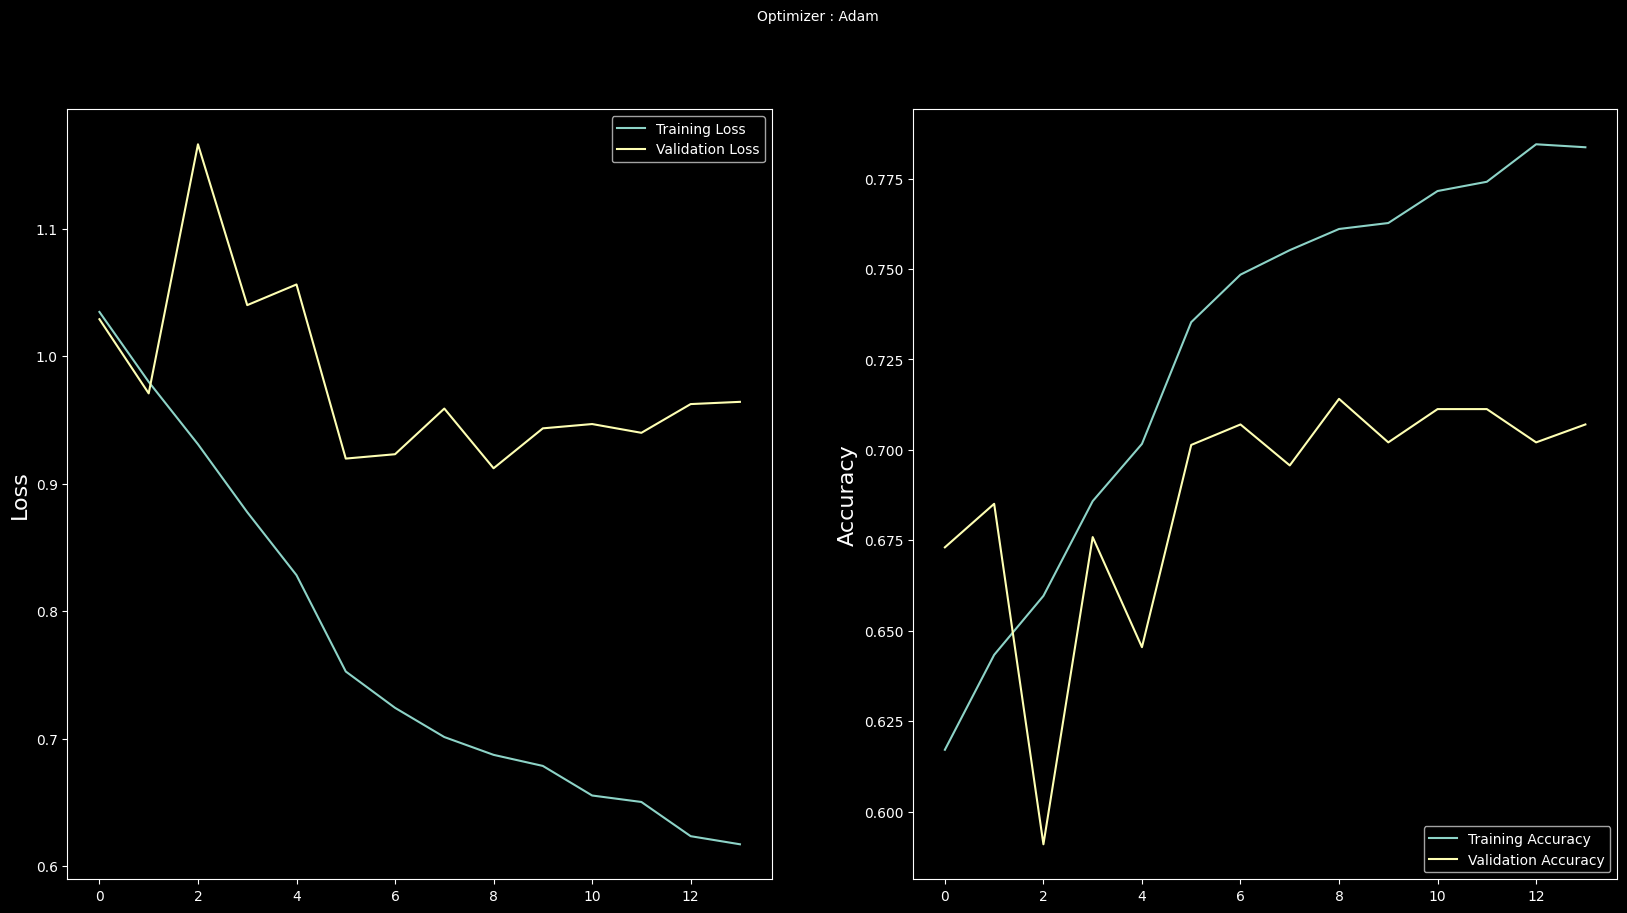

In [30]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()